In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from numpy import asarray
import os
import cv2

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()
def data_in_one(inputdata):
  min = np.nanmin(inputdata)
  max = np.nanmax(inputdata)
  output = (inputdata-min)/(max-min)
  return output

## Prepare the data

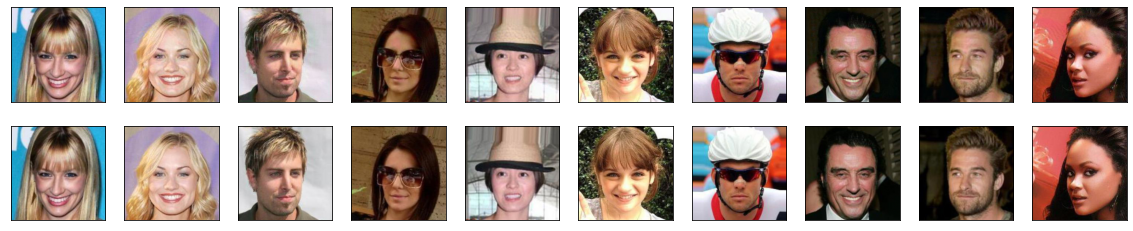

In [3]:


# Since we only need images from the dataset to encode and decode, we

# won't use the labels.
os.system('mkdir blured | mkdir results')
realDir = '/content/drive/MyDrive/real/'
perDir = '/content/drive/MyDrive/perturbed/'
source_list = sorted(os.listdir(realDir))
perturb_list = sorted(os.listdir(perDir))
oriSet = []
perSet = []

for k in range(0, len(source_list)):
  #print(realDir + source_list[k])
  #print(perDir + perturb_list[k])
  origin = Image.open( realDir + source_list[k])
  perturb = Image.open(perDir + perturb_list[k])
  oriArray = asarray(origin)
  perArray = asarray(perturb)
  oriSet.append(oriArray)
  perSet.append(perArray)

perSet = np.array(perSet)
oriSet = np.array(oriSet)
perSet = data_in_one(perSet)
oriSet = data_in_one(oriSet)
# # Display the train data and a version of it with added noise
display(perSet, oriSet)

Preprocessing the noisy training set

In [4]:
# degrading
root = '000'
os.system('mkdir blured')
for k in range(0, len(source_list)):
  #print(realDir + source_list[k])
  #print(perDir + perturb_list[k])
    origin = Image.open( realDir + source_list[k])
    #oriName = str(k) + "-R.jpg"
    #currImg = Image.fromarray((oriSet[k-1] * 255).astype(np.uint8))
    savepath = '/content/blured/' + source_list[k]
    origin.save(savepath, quality=5,optimize=True)

<class 'list'>


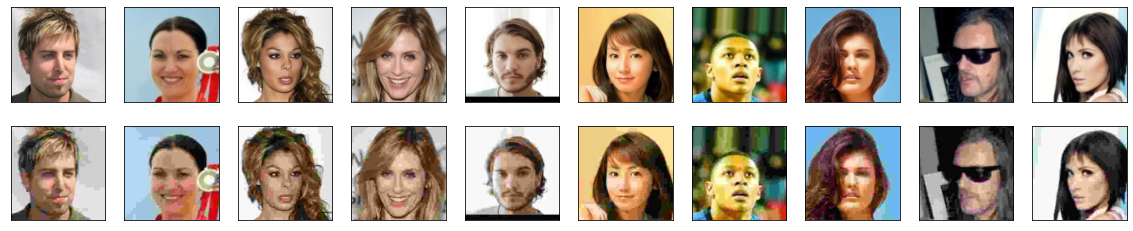

In [5]:
from numpy.lib.utils import source
#read blurring image
blurSet = []
blurDir = "/content/blured/"
blur_list = os.listdir(realDir)
print(list)
for k in range(0, len(source_list)):
  #print(realDir + source_list[k])
  #print(perDir + perturb_list[k])
  blured = Image.open( blurDir + source_list[k])
  blured = asarray(blured)
  blurSet.append(blured)

blurSet = np.array(blurSet)
blurSet = data_in_one(blurSet)
display(oriSet, blurSet)

## Build the autoencoder

We are going to use the Functional API to build our convolutional autoencoder.

In [6]:
input = layers.Input(shape=(256, 256, 3))

# Encoder
x = layers.Conv2D(64, (5, 5), activation="relu", padding="same")(input)
x = layers.AvgPool2D((2, 2), padding="same")(x)
x = layers.Conv2D(64, (5, 5), activation="relu", padding="same")(x)
x = layers.AvgPool2D((2, 2), padding="same")(x)
x = layers.Conv2D(64, (5, 5), activation="relu", padding="same")(x)
x = layers.AvgPool2D((2, 2), padding="same")(x)
x = layers.Conv2D(64, (5, 5), activation="relu", padding="same")(x)
x = layers.AvgPool2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(64, (5, 5), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (5, 5), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (5, 5), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (5, 5), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (5, 5), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      4864      
                                                                 
 average_pooling2d (AverageP  (None, 128, 128, 64)     0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      102464    
                                                                 
 average_pooling2d_1 (Averag  (None, 64, 64, 64)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        102464

In [22]:
blur = layers.Input(shape=(256, 256, 3))
# super resolution

l1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(blur)
l2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l1)
l3 = tf.keras.layers.MaxPool2D(padding='same')(l2)

l4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l3)
l5 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l4)
l6 = tf.keras.layers.MaxPool2D(padding='same')(l5)

l7 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l6)

l8 = tf.keras.layers.UpSampling2D()(l7)
l9 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l8)
l10 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l9)

l11 = tf.keras.layers.add([l10, l5])

l12 = tf.keras.layers.UpSampling2D()(l11)
l13 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l12)
l14 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l13)

l15 = tf.keras.layers.add([l14, l2])

decoded_image = tf.keras.layers.Conv2D(3, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l15)

#auto_encoder = tf.keras.models.Model(inputs=(input_img), outputs=decoded_image)
# Autoencoder
super = Model(blur, decoded_image)
super.compile(optimizer="adam", loss="binary_crossentropy")
super.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_35 (Conv2D)             (None, 256, 256, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_36 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_35[0][0]']              
                                )                                                           

Train the autoencoder model

In [9]:
autoencoder.fit(
    x=perSet,
    y=oriSet,
    epochs = 50,
    batch_size= 32 ,
    shuffle=True,
    #validation_data=(perSet, oriSet),
)

Epoch 1/50
16/16 [==============================] - 12s 129ms/step - loss: 0.6831
Epoch 2/50
16/16 [==============================] - 1s 72ms/step - loss: 0.6189
Epoch 3/50
16/16 [==============================] - 1s 71ms/step - loss: 0.5465
Epoch 4/50
16/16 [==============================] - 1s 71ms/step - loss: 0.5224
Epoch 5/50
16/16 [==============================] - 1s 71ms/step - loss: 0.5217
Epoch 6/50
16/16 [==============================] - 1s 71ms/step - loss: 0.5152
Epoch 7/50
16/16 [==============================] - 1s 71ms/step - loss: 0.5122
Epoch 8/50
16/16 [==============================] - 1s 71ms/step - loss: 0.5093
Epoch 9/50
16/16 [==============================] - 1s 71ms/step - loss: 0.5075
Epoch 10/50
16/16 [==============================] - 1s 71ms/step - loss: 0.5095
Epoch 11/50
16/16 [==============================] - 1s 71ms/step - loss: 0.5063
Epoch 12/50
16/16 [==============================] - 1s 72ms/step - loss: 0.5068
Epoch 13/50
16/16 [================

Now train the SuperResolution model

16/16 [==============================] - 1s 26ms/step


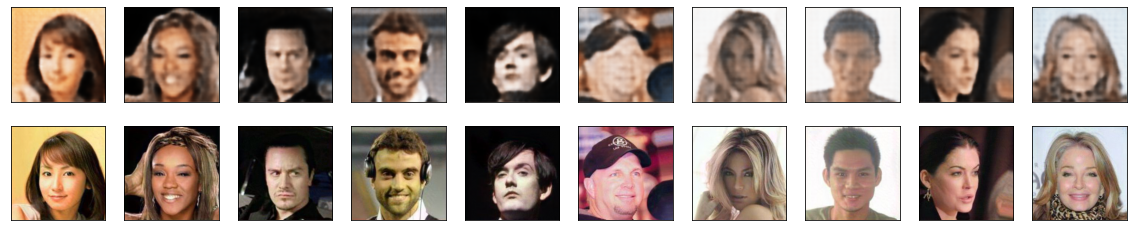

In [10]:
predictions = autoencoder.predict(perSet)
display(predictions, perSet)

In [23]:
super.fit(
    x=blurSet,
    y=oriSet,
    epochs = 50,
    batch_size=32,
    shuffle=True,
    #validation_data=(perSet, oriSet),
)

Epoch 1/50
16/16 [==============================] - 4s 176ms/step - loss: 6.6451
Epoch 2/50
16/16 [==============================] - 3s 175ms/step - loss: 6.8541
Epoch 3/50
16/16 [==============================] - 3s 176ms/step - loss: 6.8422
Epoch 4/50
16/16 [==============================] - 3s 176ms/step - loss: 6.6092
Epoch 5/50
16/16 [==============================] - 3s 176ms/step - loss: 6.8385
Epoch 6/50
16/16 [==============================] - 3s 176ms/step - loss: 4.9838
Epoch 7/50
16/16 [==============================] - 3s 175ms/step - loss: 4.3622
Epoch 8/50
16/16 [==============================] - 3s 176ms/step - loss: 3.8399
Epoch 9/50
16/16 [==============================] - 3s 176ms/step - loss: 2.5825
Epoch 10/50
16/16 [==============================] - 3s 176ms/step - loss: 2.5504
Epoch 11/50
16/16 [==============================] - 3s 175ms/step - loss: 2.5429
Epoch 12/50
16/16 [==============================] - 3s 176ms/step - loss: 2.5392
Epoch 13/50
16/16 [======

16/16 [==============================] - 1s 51ms/step


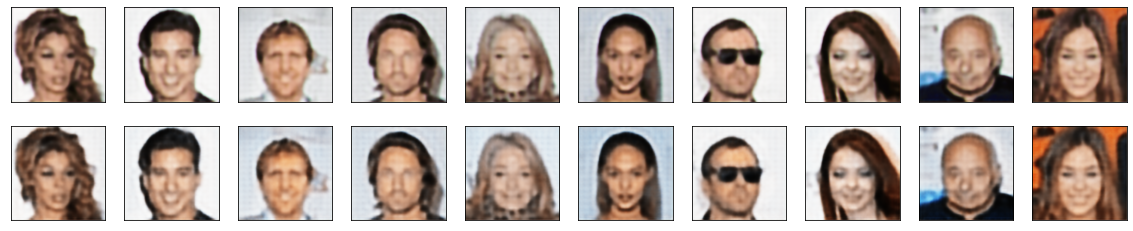

In [27]:

superRes = super.predict(predictions)
display(superRes, predictions)


Save the files

In [28]:
root = '000'
os.system('mkdir results')
for k in range(1, 502):
    if k < 10:
      oriName = root+ "00" + str(k)
    elif k >= 10 and k <= 99:
      oriName = root + "0" + str(k)
    else: 
      oriName = root + str(k)
    oriName = oriName + ".jpg"
    currImg = Image.fromarray((superRes[k-1] * 255).astype(np.uint8))
    savepath = '/content/results/' + oriName
    currImg.save(savepath)